In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"The Starless Crown, Rollins",49.207390,1.822496,7.301332,27
OAuth 2.0 RFC6749,52.328620,4.757147,8.216702,11
pfSense,67.455562,5.621297,14.675024,12
Accounting,67.991610,3.999506,8.722113,17
Pandas,147.338487,49.112829,56.633752,3
Python + Oauth2.0,367.041975,15.958347,27.273900,23
Azure Files Documentation,443.938259,13.873071,25.773608,32
Terraform,964.262150,96.426215,222.450523,10
Azure DevOps Pipelines,1081.862627,108.186263,203.172459,10
Power BI,1341.697241,40.657492,61.757091,33


# Histogram

sum of ages: ~50169.78


<Axes: >

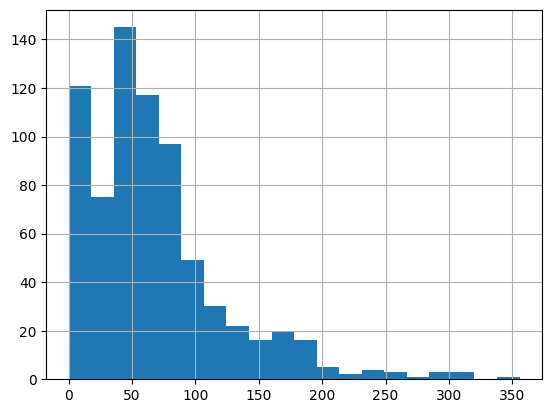

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~50169.78


<Axes: >

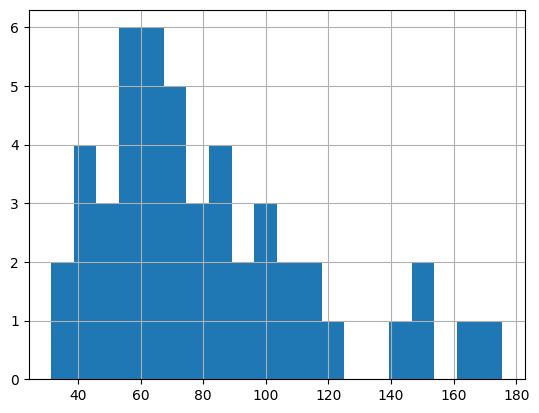

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Microsoft Purview']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 730
Total card age: 50169.78


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
0,Azure Developer Associate,Your company is developing a new web applicati...,466f3aae7fb7958ec8752dd6ace75557,-355.649202,-218.090365,355.649202,1744.722916,0.616786,8,0,0
1,Azure Developer Associate,"In the .NET SDK for Azure Cosmos DB for NoSQL,...",aeb02c24e551b80ec7573284fbb0fc82,-229.036875,-218.090365,355.649202,1744.722916,0.616786,8,3,0
2,Azure Developer Associate,You plan to implement a storage mechanism for ...,bd10ecb376186d364d36592c337f9cd9,-139.266062,-218.090365,355.649202,1744.722916,0.616786,8,6,0
3,Azure DevOps Pipelines,How do you run a pipeline on a self-hosted age...,0ac1ed550c9daa2946b919787429b4fc,-203.172459,-108.186263,203.172459,1081.862627,0.573361,10,0,0
4,Azure DevOps Pipelines,What does the 'variables' keyword do in a YAML...,add1c4206436b2b993c8a77191d15d0b,-103.986598,-108.186263,203.172459,1081.862627,0.573361,10,3,0
5,Azure DevOps Pipelines,"In Azure DevOps, what command is used to run a...",5843789a2ab93c36fae15bce2e58199b,-76.758584,-108.186263,203.172459,1081.862627,0.573361,10,6,0
6,Azure DevOps Pipelines,"In an Azure DevOps pipeline, which YAML syntax...",b13f80422b178a697f56625737302c5b,-68.246835,-108.186263,203.172459,1081.862627,0.573361,10,9,0
7,C# Basics,What are common libraries and frameworks in C#...,d714cbc1740b344f84ed84278b332f36,-312.915159,-104.590555,312.915159,2510.173330,0.842976,24,0,0
8,C# Basics,An interface defines a contract that classes m...,e985b04311fcd2494bb5725cf33b2986,-174.556753,-104.590555,312.915159,2510.173330,0.842976,24,3,0
9,C# Basics,A constructor is a special method used to init...,cff83ac94df0a7e5f6ce64eb8d98220d,-115.577374,-104.590555,312.915159,2510.173330,0.842976,24,6,0


## Age Max

In [10]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [11]:
# n=4
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(-1779.1659023447273)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
0,Azure Developer Associate,Your company is developing a new web applicati...,466f3aae7fb7958ec8752dd6ace75557,-355.649202,-218.090365,355.649202,1744.722916,0.616786,8,0,0
61,Python,Q:\nWhat is the primary purpose of exit codes ...,d5ae26a1eb6bf1e733080a8396f21e2d,-316.304365,-92.817736,316.304365,4919.339997,0.491126,53,0,0
7,C# Basics,What are common libraries and frameworks in C#...,d714cbc1740b344f84ed84278b332f36,-312.915159,-104.590555,312.915159,2510.173330,0.842976,24,0,0
37,FSLogix,A full VHD(x) clone is performed when Cloud Ca...,71af619ba0f37ffd62aa637176cd6ef4,-312.313484,-95.604395,312.313484,1720.879104,0.432289,18,0,0
300,Python,Q:\nHow can you define a custom exception in P...,42a1f83efefd4b56173827e48cae56f3,-287.613787,-92.817736,316.304365,4919.339997,0.491126,53,1,1
243,Azure Developer Associate,As the .NET SDK for Azure Cosmos DB for NoSQL ...,e7d9d1bada8400673bd3bdf99e9f3c40,-287.521901,-218.090365,355.649202,1744.722916,0.616786,8,1,1
102,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,-287.405734,-87.830442,287.405734,4303.691679,0.505693,49,0,0
43,Asynchronous Python,"Thread Pool Executor\nA thread pool executor, ...",102c628cf04ad4661a71d437cd297a11,-284.477604,-95.316233,284.477604,2668.854511,0.911613,28,0,0
318,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,-255.030216,-91.654110,255.030216,3482.856196,0.906447,38,0,0
79,PnP PowerShell,Invoke-RestMethod Parameters\nKey parameters i...,e6a04d0a76f2a4a9cba720d23ffea2c8,-249.705257,-91.654110,255.030216,3482.856196,0.906447,38,1,1


In [15]:
existing_cards['age'].mean()

np.float64(-68.72572872603178)